# Dataset

### Download the data from kaggle

In [1]:
import os
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d scribbless/another-anime-face-dataset
!unzip -q another-anime-face-dataset.zip -d dataset
!rm another-anime-face-dataset.zip
!mv dataset/animefaces256cleaner dataset/target

100% 1.44G/1.44G [01:06<00:00, 30.3MB/s]
100% 1.44G/1.44G [01:06<00:00, 23.2MB/s]


In [4]:
target_dir = 'dataset/target/'

In [5]:
files = [target_dir + file_name for file_name in os.listdir(target_dir)]
len(files)

92219

In [6]:
files[:5]

['dataset/target/56658746_result.jpg',
 'dataset/target/29562516_result.jpg',
 'dataset/target/40397189_result.jpg',
 'dataset/target/81178096_result.jpg',
 'dataset/target/38336680_result.jpg']

### Prepare the data

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [8]:
def preprocess_image(file_path):
    images = tf.io.read_file(file_path)
    images = tf.image.decode_jpeg(images, channels=3)
    images = tf.image.resize(images, (64, 64), method='bicubic', antialias=True)
    images = (images - 127.5) / 127.5 # Normalize the images to [-1, 1]
    return images

In [9]:
files_tf = tf.data.Dataset.from_tensor_slices(files)
train_data = files_tf.map(preprocess_image).shuffle(1000).batch(64)
len(train_data)

1441

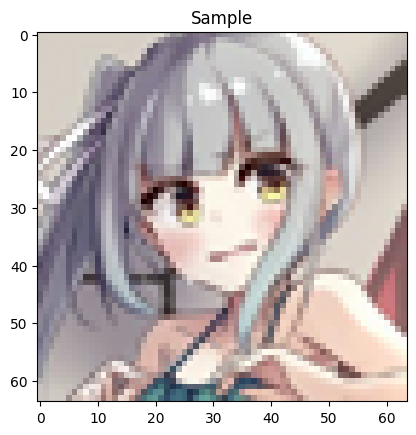

In [10]:
sample_img = next(iter(train_data))
plt.title('Sample')
plt.imshow(sample_img[0] * 0.5 + 0.5)

# Models Building

### Generator

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import (Layer, Conv2D, Conv2DTranspose, Activation, Reshape,
                                     LayerNormalization, BatchNormalization, Input, Dropout,
                                     Concatenate, Dense, LeakyReLU, Flatten)
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import plot_model

In [12]:
NOISE_DIM = 128
input = Input(NOISE_DIM)

z = Dense(4*4*512, use_bias=False)(input)
z = Reshape((4, 4, 512))(z)

x = Conv2DTranspose(512, 4, 1, padding='same', use_bias=False)(z)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(256, 4, 2, padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(128, 4, 2, padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(64, 4, 2, padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

output = Conv2DTranspose(3, 4, 2, padding='same', use_bias=False, activation="tanh")(x)

generator = Model(inputs=input, outputs=output)

In [13]:
# generator.summary()
# plot_model(generator, show_shapes=True, dpi=64)

In [14]:
disc_opt = Adam()

### Discriminator

In [15]:
input_shape = (64, 64, 3)
input = Input(input_shape)

x = Conv2D(64, 4, 2, padding='same', use_bias=False)(input)
# x = LayerNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(128, 4, 2, padding='same', use_bias=False)(x)
# x = LayerNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(256, 4, 2, padding='same', use_bias=False)(x)
# x = LayerNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(512, 4, 2, padding='same', use_bias=False)(x)
# x = LayerNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(1, 4, 1, padding='same', use_bias=False)(x)

x = Flatten()(x)
output = Dense(1)(x)

discriminator = Model(inputs=input, outputs=output)

In [16]:
# discriminator.summary()
# plot_model(discriminator, show_shapes=True, dpi=64)

In [17]:
gen_opt = Adam()

# Training

### Prepare for Training

In [18]:
results_dir = 'results'
if not os.path.exists(results_dir) : os.mkdir(results_dir)

def generate_and_save_images(model, epoch, test_input, save=True, is_flatten=False):
    predictions = model.predict(test_input)
    if is_flatten: predictions = predictions.reshape(-1, 64, 64, 3).astype('float32')

    fig = plt.figure(figsize=(12, 6))
    for i in range(18):
        plt.subplot(3, 6, i+1)
        plt.imshow(predictions[i] * 0.5 + 0.5)
        plt.axis('off')
    if save: plt.savefig(os.path.join(results_dir, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

1/1 [==============================] - 2s 2s/step


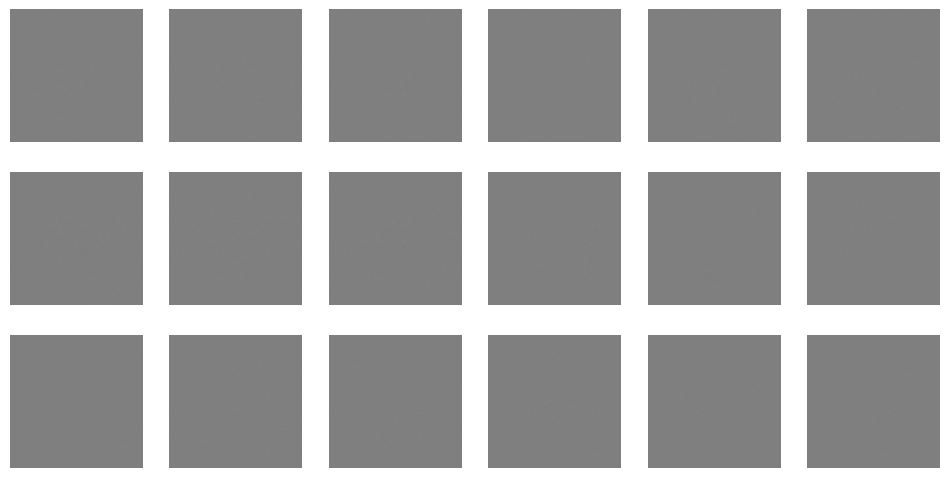

In [19]:
sample_noise = tf.random.normal([18, 128])
generate_and_save_images(generator, 1, [sample_noise], save=False, is_flatten=False)

### Training Functions

In [20]:
LAMBDA = 10

@tf.function
def disc_train_step(real_image, batch_size, step):
    noise = tf.random.normal([batch_size, NOISE_DIM])
    epsilon = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0, maxval=1)

    with tf.GradientTape(persistent=True) as d_tape:
        with tf.GradientTape() as gp_tape:
            fake_image = generator([noise], training=True)
            fake_image_mixed = epsilon * tf.dtypes.cast(real_image, tf.float32) + ((1 - epsilon) * fake_image)
            fake_mixed_pred = discriminator([fake_image_mixed], training=True)

        grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
        grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))

        fake_pred = discriminator([fake_image], training=True)
        real_pred = discriminator([real_image], training=True)

        disc_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty

    disc_grads = d_tape.gradient(disc_loss, discriminator.trainable_variables)
    disc_opt.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

In [21]:
@tf.function
def gen_train_step(batch_size, step):
    noise = tf.random.normal([batch_size, NOISE_DIM])
    with tf.GradientTape() as g_tape:
        fake_image = generator([noise], training=True)
        fake_pred = discriminator([fake_image], training=True)
        gen_loss = -tf.reduce_mean(fake_pred)

    gen_grads = g_tape.gradient(gen_loss, generator.trainable_variables)
    gen_opt.apply_gradients(zip(gen_grads, generator.trainable_variables))

### Training

In [22]:
from tensorflow.keras import backend as K
from tqdm import tqdm

100%|██████████| 1441/1441 [02:27<00:00,  9.75it/s]

1/1 [==============================] - 0s 30ms/step


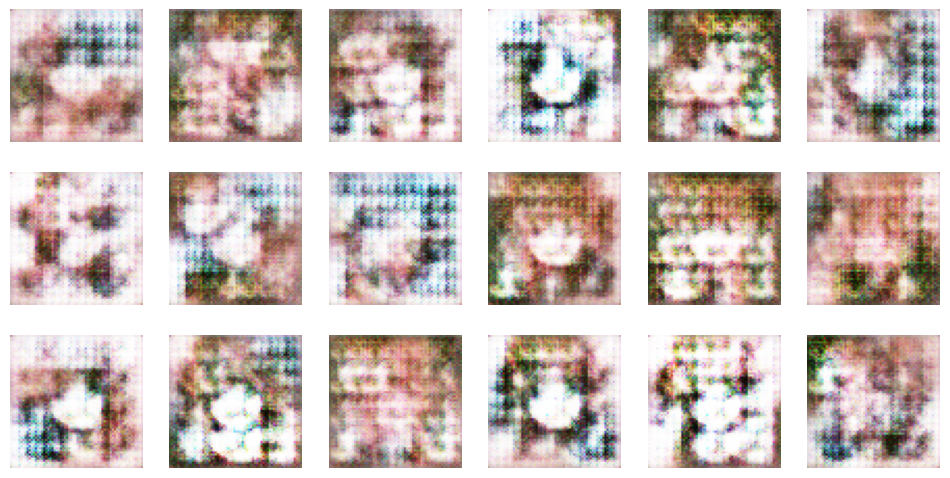

100%|██████████| 1441/1441 [02:21<00:00, 10.17it/s]

1/1 [==============================] - 0s 27ms/step


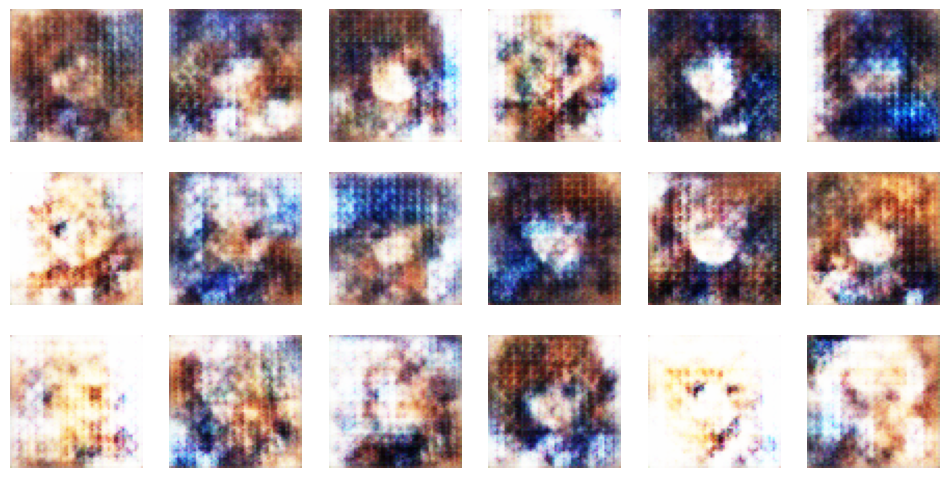

100%|██████████| 1441/1441 [02:24<00:00,  9.94it/s]

1/1 [==============================] - 0s 20ms/step


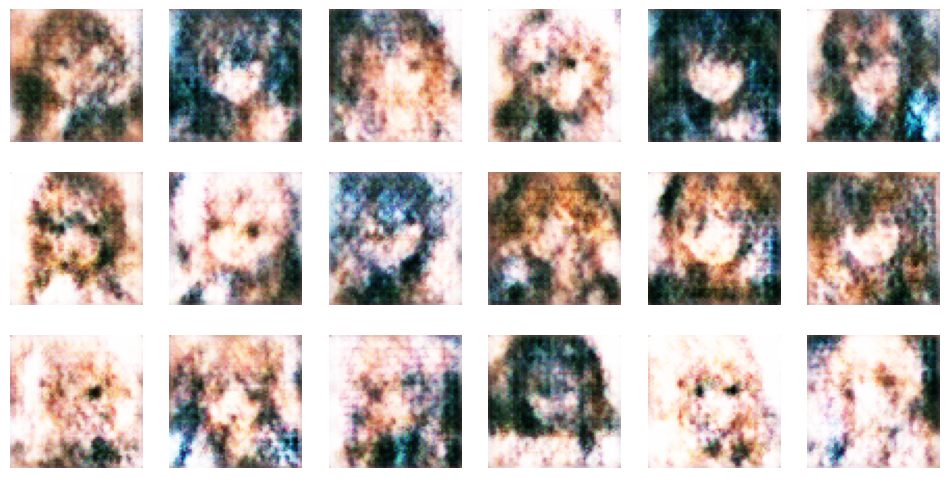

In [23]:
lr = 0.0001
min_lr = 0.00001
decay_factor = 1.00004
epochs = 3
N_CRITIC = 3
n_critic_count = 0

for epoch in range(1, epochs + 1):
    new_lr = max(lr / decay_factor, min_lr)
    K.set_value(disc_opt.lr, new_lr)
    K.set_value(gen_opt.lr, new_lr)

    for step, (image) in tqdm(enumerate(train_data), total=len(train_data)):
        current_batch_size = image.shape[0]
        # Train critic (discriminator)
        disc_train_step(image, batch_size=tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
        n_critic_count += 1
        if n_critic_count >= N_CRITIC:
            # Train generator
            gen_train_step(batch_size = tf.constant(current_batch_size, dtype=tf.int64), step = tf.constant(step, dtype=tf.int64))
            n_critic_count = 0

    generate_and_save_images(generator, epoch, [sample_noise], save=True, is_flatten=False)